In [5]:
# !pip install lazypredict
# !pip install imbalanced-learn
# !pip install optuna

In [6]:
from lazypredict.Supervised import LazyClassifier  # use LazyRegressor for regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

import pandas as pd


In [7]:
import optuna
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestCentroid
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [8]:
sample_df=pd.read_csv("D:/DA-EBPL/Sample_submission.csv")

In [9]:
Train_df=pd.read_csv("D:/DA-EBPL/Train.csv")

In [10]:
Test_df=pd.read_csv("D:/DA-EBPL/Test.csv")

In [11]:
Train_df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558,Class
0,100,160,1.60,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20,83,4.15,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,99,150,1.52,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,40,40,1.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12,234,19.50,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
Test_df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_1549,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558
0,60.00,468.00,7.80,1.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,108.00,179.00,1.66,1.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.00,1.00,2.00,0.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,60.00,468.00,7.80,1.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,60.00,120.00,2.00,1.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
sample_df.head()

,Class
0,0.00
1,0.00
2,0.00
3,0.00
4,0.00


In [14]:
Train_df.shape

(1763, 1559)

In [15]:
## EDA

In [16]:
Train_df["Class"].value_counts()

Class
0    1620
1     143
Name: count, dtype: int64

In [17]:
Bool_cols=[ i for i in Train_df.columns.to_list() if Train_df[i].nunique()==2]

In [18]:
len(Bool_cols)

1520

In [19]:
Other_cols=set(Train_df.columns.to_list())-set(Bool_cols)

In [20]:
len(Other_cols)

39

In [21]:
Train_df[list(Bool_cols)].sum()

feature_4       1277
feature_5          5
feature_6          5
feature_7         14
feature_8          4
                ... 
feature_1555      27
feature_1556      26
feature_1557      17
feature_1558       2
Class            143
Length: 1520, dtype: int64

In [22]:
Train_df["feature_4"].nunique()

2

In [23]:
No_variance_column=[i for i in Other_cols if Train_df[i].nunique() ==1]

In [24]:
Train_df[list(No_variance_column)].sum()

feature_978     0
feature_894     0
feature_383     0
feature_435     0
feature_106     0
feature_147     0
feature_630     0
feature_1038    0
feature_57      0
feature_652     0
feature_531     0
feature_372     0
feature_1243    0
feature_1063    0
feature_284     0
feature_522     0
feature_495     0
feature_1096    0
feature_1211    0
feature_1185    0
feature_320     0
feature_488     0
feature_631     0
feature_262     0
feature_934     0
feature_1367    0
feature_1407    0
feature_1247    0
feature_591     0
feature_578     0
feature_362     0
feature_82      0
feature_1341    0
feature_439     0
feature_553     0
feature_278     0
dtype: int64

In [25]:
Train_df[list(Other_cols)].describe()

,feature_978,feature_894,feature_383,feature_435,feature_106,feature_147,feature_630,feature_1038,feature_57,feature_652,...,feature_1407,feature_1247,feature_591,feature_578,feature_362,feature_82,feature_1341,feature_439,feature_553,feature_278
count,1763.00,1763.00,1763.00,1763.00,1763.00,1763.00,1763.00,1763.00,1763.00,1763.00,...,1763.00,1763.00,1763.00,1763.00,1763.00,1763.00,1763.00,1763.00,1763.00,1763.00
mean,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
std,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [26]:
Valid_other_cols=set(Other_cols)-set(No_variance_column)

In [27]:
len(Valid_other_cols)

3

In [28]:
Train_df[list(Valid_other_cols)].corr()

,feature_2,feature_1,feature_3
feature_2,1.00,0.36,0.52
feature_1,0.36,1.00,-0.21
feature_3,0.52,-0.21,1.00


In [29]:
bool_corr=Train_df[list(Bool_cols)].corr()

In [30]:
bool_corr

,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,...,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558,Class
feature_4,1.00,0.03,-0.01,0.06,0.03,0.00,0.07,0.03,-0.13,0.03,...,0.02,0.03,0.03,-0.02,0.04,-0.01,-0.01,-0.00,0.02,0.02
feature_5,0.03,1.00,-0.00,-0.00,-0.00,-0.00,-0.01,-0.00,-0.00,-0.00,...,-0.00,-0.00,-0.00,-0.00,-0.00,-0.01,-0.01,-0.01,-0.00,-0.02
feature_6,-0.01,-0.00,1.00,-0.00,-0.00,-0.00,-0.01,-0.00,-0.00,-0.00,...,-0.00,-0.00,-0.00,-0.00,-0.00,-0.01,-0.01,-0.01,-0.00,-0.02
feature_7,0.06,-0.00,-0.00,1.00,-0.00,-0.01,-0.01,-0.00,-0.01,-0.01,...,-0.01,-0.01,-0.00,-0.01,-0.01,-0.01,-0.01,-0.01,-0.00,-0.03
feature_8,0.03,-0.00,-0.00,-0.00,1.00,-0.00,-0.01,-0.00,-0.00,-0.00,...,-0.00,-0.00,-0.00,-0.00,-0.00,-0.01,-0.01,-0.00,-0.00,-0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
feature_1555,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,0.07,-0.01,-0.01,-0.01,...,-0.01,-0.01,0.17,-0.01,-0.01,1.00,0.98,0.51,-0.00,0.13
feature_1556,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,0.03,-0.01,-0.01,-0.01,...,-0.01,-0.01,0.17,-0.01,-0.01,0.98,1.00,0.52,-0.00,0.14
feature_1557,-0.00,-0.01,-0.01,-0.01,-0.00,-0.01,0.04,-0.00,-0.01,-0.01,...,-0.01,-0.01,0.10,-0.01,-0.01,0.51,0.52,1.00,0.17,0.08
feature_1558,0.02,-0.00,-0.00,-0.00,-0.00,-0.00,0.15,-0.00,-0.00,-0.00,...,-0.00,0.22,-0.00,-0.00,-0.00,-0.00,-0.00,0.17,1.00,-0.01


In [31]:
import pandas as pd

def get_high_correlations(df, threshold=0.5):
    corr = df.corr()

    # Unstack and reset index
    corr_pairs = corr.unstack().reset_index()
    corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']

    # Remove self-correlations
    corr_pairs = corr_pairs[corr_pairs['Feature1'] != corr_pairs['Feature2']]

    # Remove duplicate pairs (A-B and B-A)
    corr_pairs['Sorted'] = corr_pairs.apply(lambda x: tuple(sorted([x['Feature1'], x['Feature2']])), axis=1)
    corr_pairs = corr_pairs.drop_duplicates('Sorted').drop(columns='Sorted')

    # Filter by threshold
    filtered = corr_pairs[(corr_pairs['Correlation'] > threshold) | (corr_pairs['Correlation'] < threshold*-1)]

    return filtered


In [32]:
bool_corr=get_high_correlations(df=Train_df[list(Bool_cols)], threshold=0.95)

In [33]:
bool_corr

,Feature1,Feature2,Correlation
3277,feature_6,feature_245,1.00
3510,feature_6,feature_487,1.00
3612,feature_6,feature_596,1.00
4880,feature_7,feature_332,1.00
5155,feature_7,feature_619,1.00
...,...,...,...
2188746,feature_1479,feature_1506,0.96
2200925,feature_1487,feature_1525,1.00
2284555,feature_1542,feature_1555,0.98
2284556,feature_1542,feature_1556,1.00


In [34]:
dict1={}
related_feature=[]
for i in list(bool_corr.query("Correlation== 1").Feature1.unique()):
  if i not in related_feature:
    dict1[i]=list(bool_corr[bool_corr.Feature1==i].Feature2.unique())
    related_feature.extend(list(bool_corr[bool_corr.Feature1==i].Feature2.unique()))


In [35]:
len(dict1.keys())

241

In [36]:
len(dict1.keys())

241

In [37]:
len(bool_corr.query("Correlation== 1").Feature1.unique())-len(dict1.keys())

553

In [38]:
Co_related_columns=list(set(bool_corr.query("Correlation== 1").Feature1.unique())-set(dict1.keys()))

In [39]:
len(No_variance_column)

36

In [40]:
len(Co_related_columns+list(No_variance_column))

589

In [41]:
No_variance_column,

(['feature_978',
  'feature_894',
  'feature_383',
  'feature_435',
  'feature_106',
  'feature_147',
  'feature_630',
  'feature_1038',
  'feature_57',
  'feature_652',
  'feature_531',
  'feature_372',
  'feature_1243',
  'feature_1063',
  'feature_284',
  'feature_522',
  'feature_495',
  'feature_1096',
  'feature_1211',
  'feature_1185',
  'feature_320',
  'feature_488',
  'feature_631',
  'feature_262',
  'feature_934',
  'feature_1367',
  'feature_1407',
  'feature_1247',
  'feature_591',
  'feature_578',
  'feature_362',
  'feature_82',
  'feature_1341',
  'feature_439',
  'feature_553',
  'feature_278'],)

In [42]:
Train_df.shape[1]-553-1-36-3 # valid Bool Columns

966

In [43]:
Train_df[["Class","feature_1"]].value_counts()

Class  feature_1
0      1            339
       60           108
       12            81
1      60            70
0      11            49
                   ... 
       191            1
       185            1
       183            1
       174            1
1      240            1
Name: count, Length: 215, dtype: int64

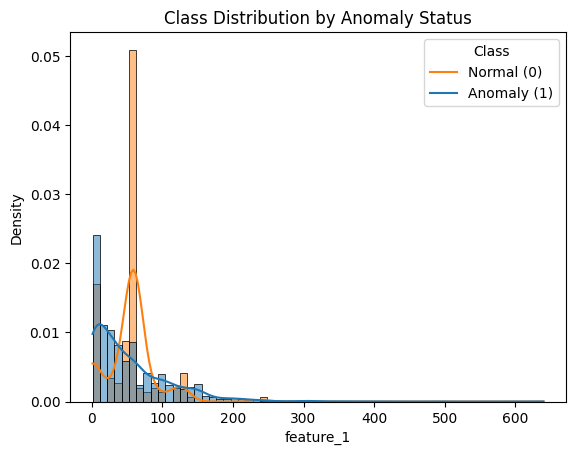

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example: df['temperature'] is numeric, df['anomaly'] is 0 or 1
sns.histplot(data=Train_df, x='feature_1', hue='Class', kde=True, stat='density', common_norm=False)

plt.title("Class Distribution by Anomaly Status")
plt.xlabel("feature_1")
plt.ylabel("Density")
plt.legend(title='Class', labels=['Normal (0)', 'Anomaly (1)'])
plt.show()

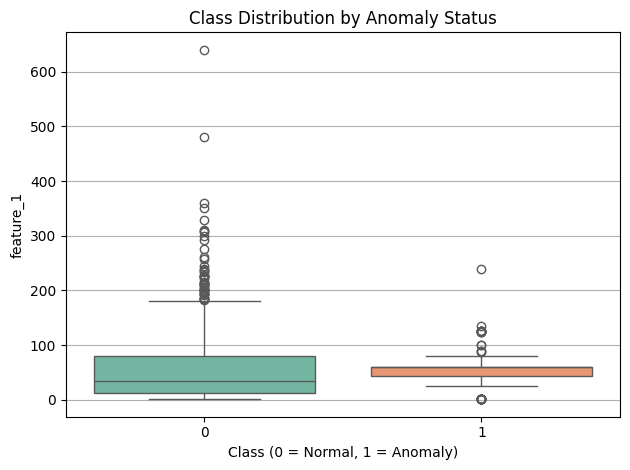

In [45]:
# Example: 'temperature' is numeric, 'anomaly' is binary (0 or 1)
sns.boxplot(data=Train_df, x='Class', y='feature_1', palette='Set2')

plt.title("Class Distribution by Anomaly Status")
plt.ylabel("feature_1")
plt.xlabel("Class (0 = Normal, 1 = Anomaly)")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


In [46]:
# Feature Engineering (Remove or Modified Unwanted columns)

In [47]:
Train_dataset=Train_df.drop(columns=Co_related_columns+list(No_variance_column))

In [48]:
X=Train_dataset.drop(columns="Class")
y=Train_dataset["Class"]

In [49]:
# Split manually, if not already split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [50]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, y_train, X_test, y_test)
display(models)

  0%|          | 0/32 [00:00<?, ?it/s]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,


In [51]:
# prediction Model Fine tuning

In [52]:
def lazy_classifier_metrics_from_split(
    X_train, X_test, y_train, y_test, top_n=10, calculate_roc_auc=True
):
    """
    Evaluate top N LazyClassifier models with train/test metrics for binary classification.
    Checks only for NaNs in predicted probabilities.
    """

    clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
    models, predictions = clf.fit(X_train, X_test, y_train, y_test)

    top_models = models.head(top_n)

    metrics = []

    for model_name in top_models.index:
        model = clf.models[model_name]
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        if calculate_roc_auc:
            try:
                y_train_proba = model.predict_proba(X_train)[:, 1]
                y_test_proba = model.predict_proba(X_test)[:, 1]

                if pd.isna(y_train_proba).any() or pd.isna(y_test_proba).any():
                    print(f"Warning: NaNs detected in predicted probabilities for model {model_name}")

                train_roc = roc_auc_score(y_train, y_train_proba)
                test_roc = roc_auc_score(y_test, y_test_proba)

            except (AttributeError, NotImplementedError, ValueError) as e:
                print(f"Warning: Could not compute ROC AUC for model {model_name}: {e}")
                train_roc = None
                test_roc = None
        else:
            train_roc = None
            test_roc = None

        metrics.append({
            "Model": model_name,
            "Test Accuracy": accuracy_score(y_test, y_test_pred),
            "Train Accuracy": accuracy_score(y_train, y_train_pred),
            "Test F1 Score": f1_score(y_test, y_test_pred, zero_division=0),
            "Train F1 Score": f1_score(y_train, y_train_pred, zero_division=0),
            "Test Precision": precision_score(y_test, y_test_pred, zero_division=0),
            "Train Precision": precision_score(y_train, y_train_pred, zero_division=0),
            "Test Recall": recall_score(y_test, y_test_pred, zero_division=0),
            "Train Recall": recall_score(y_train, y_train_pred, zero_division=0),
            "Test ROC AUC": test_roc,
            "Train ROC AUC": train_roc
        })

    results_df = pd.DataFrame(metrics)[[
        "Model",
        "Test Accuracy", "Train Accuracy",
        "Test F1 Score", "Train F1 Score",
        "Test Precision", "Train Precision",
        "Test Recall", "Train Recall",
        "Test ROC AUC", "Train ROC AUC"
    ]]

    return results_df.round(4)

In [53]:
from sklearn.preprocessing import StandardScaler

In [54]:
def lazy_classifier_metrics_from_split_standard_scaler(
    X_train, X_test, y_train, y_test, top_n=10, calculate_roc_auc=True
):
    """
    Evaluate top N LazyClassifier models with train/test metrics for binary classification.
    Checks only for NaNs in predicted probabilities.
    """
    scaler = StandardScaler()

    # Fit on train data only
    X_train_scaled = scaler.fit_transform(X_train)

    # Transform test data
    X_test_scaled = scaler.transform(X_test)

    clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
    models, predictions = clf.fit(X_train_scaled, X_test_scaled, y_train, y_test)

    top_models = models.head(top_n)
    display(top_models)

    metrics = []

    for model_name in top_models.index:
        model = clf.models[model_name]
        model.fit(X_train_scaled, y_train)

        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)

        if calculate_roc_auc:
            try:
                y_train_proba = model.predict_proba(X_train_scaled)[:, 1]
                y_test_proba = model.predict_proba(X_test_scaled)[:, 1]

                if pd.isna(y_train_proba).any() or pd.isna(y_test_proba).any():
                    print(f"Warning: NaNs detected in predicted probabilities for model {model_name}")

                train_roc = roc_auc_score(y_train, y_train_proba)
                test_roc = roc_auc_score(y_test, y_test_proba)

            except (AttributeError, NotImplementedError, ValueError) as e:
                print(f"Warning: Could not compute ROC AUC for model {model_name}: {e}")
                train_roc = None
                test_roc = None
        else:
            train_roc = None
            test_roc = None

        metrics.append({
            "Model": model_name,
            "Test Accuracy": accuracy_score(y_test, y_test_pred),
            "Train Accuracy": accuracy_score(y_train, y_train_pred),
            "Test F1 Score": f1_score(y_test, y_test_pred, zero_division=0),
            "Train F1 Score": f1_score(y_train, y_train_pred, zero_division=0),
            "Test Precision": precision_score(y_test, y_test_pred, zero_division=0),
            "Train Precision": precision_score(y_train, y_train_pred, zero_division=0),
            "Test Recall": recall_score(y_test, y_test_pred, zero_division=0),
            "Train Recall": recall_score(y_train, y_train_pred, zero_division=0),
            "Test ROC AUC": test_roc,
            "Train ROC AUC": train_roc
        })

    results_df = pd.DataFrame(metrics)[[
        "Model",
        "Test Accuracy", "Train Accuracy",
        "Test F1 Score", "Train F1 Score",
        "Test Precision", "Train Precision",
        "Test Recall", "Train Recall",
        "Test ROC AUC", "Train ROC AUC"
    ]]

    return results_df.round(4)

In [55]:
X_train.isna().sum().sum(),X_test.isna().sum().sum(),y_train.isna().sum().sum(),y_test.isna().sum().sum()

(np.int64(0), np.int64(0), np.int64(0), np.int64(0))

In [56]:
from sklearn.preprocessing import StandardScaler




In [57]:
# Get metrics
metrics_df_normal = lazy_classifier_metrics_from_split(X_train, X_test, y_train, y_test)
display(metrics_df_normal)



  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 114, number of negative: 1296
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 911
[LightGBM] [Info] Number of data points in the train set: 1410, number of used features: 133
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080851 -> initscore=-2.430839
[LightGBM] [Info] Start training from score -2.430839
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,Model,Test Accuracy,Train Accuracy,Test F1 Score,Train F1 Score,Test Precision,Train Precision,Test Recall,Train Recall,Test ROC AUC,Train ROC AUC
0,BernoulliNB,0.90,0.92,0.53,0.59,0.44,0.52,0.66,0.68,0.87,0.93
1,NearestCentroid,0.90,0.93,0.50,0.60,0.44,0.56,0.59,0.66,0.87,0.95
2,ExtraTreeClassifier,0.88,1.00,0.38,0.97,0.33,1.00,0.45,0.95,0.68,1.00
3,BaggingClassifier,0.90,0.99,0.40,0.93,0.39,0.96,0.41,0.89,0.85,1.00
4,RandomForestClassifier,0.90,1.00,0.39,0.97,0.38,0.99,0.41,0.96,0.89,1.00
5,GaussianNB,0.78,0.83,0.28,0.48,0.19,0.32,0.52,1.00,0.66,0.91
6,ExtraTreesClassifier,0.88,1.00,0.34,0.97,0.31,1.00,0.38,0.95,0.78,1.00
7,XGBClassifier,0.91,0.99,0.38,0.90,0.42,0.94,0.34,0.87,0.89,1.00
8,DecisionTreeClassifier,0.89,1.00,0.34,0.97,0.33,1.00,0.34,0.95,0.66,1.00
9,AdaBoostClassifier,0.91,0.93,0.35,0.46,0.41,0.61,0.31,0.37,0.89,0.95


In [58]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


In [59]:
# Oversampling with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Undersampling with RandomUnderSampler
under = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = under.fit_resample(X_train, y_train)


In [60]:

# Run LazyPredict on SMOTE oversampled data
print("=== LazyClassifier with SMOTE (Oversampling) ===")
# Get metrics
metrics_df_smote = lazy_classifier_metrics_from_split(X_train_smote, X_test, y_train_smote, y_test)
display(metrics_df_smote)



=== LazyClassifier with SMOTE (Oversampling) ===


  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 1296, number of negative: 1296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1138
[LightGBM] [Info] Number of data points in the train set: 2592, number of used features: 178
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 1296, number of negative: 1296
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1138
[LightGBM] [Info] Number of data points in the train set: 2592, number of used features: 178
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,Model,Test Accuracy,Train Accuracy,Test F1 Score,Train F1 Score,Test Precision,Train Precision,Test Recall,Train Recall,Test ROC AUC,Train ROC AUC
0,BernoulliNB,0.84,0.92,0.42,0.92,0.30,0.88,0.72,0.97,0.84,0.94
1,AdaBoostClassifier,0.85,0.79,0.42,0.77,0.31,0.88,0.66,0.68,0.84,0.90
2,NearestCentroid,0.83,0.92,0.39,0.92,0.28,0.88,0.66,0.97,0.83,0.95
3,RandomForestClassifier,0.82,1.00,0.35,1.00,0.25,0.99,0.59,1.00,0.84,1.00
4,KNeighborsClassifier,0.79,0.94,0.31,0.94,0.21,0.90,0.59,0.98,0.80,0.99
5,XGBClassifier,0.84,0.95,0.35,0.95,0.26,0.96,0.52,0.95,0.85,0.99
6,DecisionTreeClassifier,0.81,1.00,0.31,1.00,0.22,1.00,0.52,1.00,0.68,1.00
7,BaggingClassifier,0.81,0.99,0.29,0.99,0.21,0.99,0.48,0.99,0.83,1.00
8,GaussianNB,0.78,0.91,0.28,0.91,0.19,0.84,0.52,1.00,0.66,0.91
9,LGBMClassifier,0.83,0.95,0.30,0.95,0.23,0.96,0.45,0.95,0.85,0.99


In [61]:

# Run LazyPredict on Undersampled data
print("\n=== LazyClassifier with RandomUnderSampler ===")
metrics_df_under = lazy_classifier_metrics_from_split(X_train_under, X_test, y_train_under, y_test)
display(metrics_df_under)




=== LazyClassifier with RandomUnderSampler ===


  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 114, number of negative: 114
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 228, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

,Model,Test Accuracy,Train Accuracy,Test F1 Score,Train F1 Score,Test Precision,Train Precision,Test Recall,Train Recall,Test ROC AUC,Train ROC AUC
0,LGBMClassifier,0.84,0.93,0.50,0.93,0.34,0.92,0.93,0.94,0.92,0.97
1,BaggingClassifier,0.84,0.99,0.49,0.99,0.33,1.00,0.90,0.97,0.90,1.00
2,XGBClassifier,0.82,0.97,0.44,0.97,0.30,0.98,0.90,0.96,0.91,1.00
3,RandomForestClassifier,0.87,1.00,0.49,1.00,0.37,1.00,0.76,1.00,0.90,1.00
4,DecisionTreeClassifier,0.78,1.00,0.39,1.00,0.25,1.00,0.86,1.00,0.82,1.00
5,AdaBoostClassifier,0.85,0.88,0.45,0.87,0.32,0.90,0.76,0.85,0.83,0.93
6,BernoulliNB,0.89,0.86,0.51,0.84,0.41,0.93,0.69,0.77,0.87,0.94
7,CalibratedClassifierCV,0.77,1.00,0.37,1.00,0.24,1.00,0.83,0.99,0.86,1.00
8,ExtraTreesClassifier,0.83,1.00,0.42,1.00,0.29,1.00,0.72,1.00,0.85,1.00
9,LinearSVC,0.74,1.00,0.34,1.00,0.21,1.00,0.83,1.00,NaN,NaN


In [62]:
# Get metrics
metrics_df_normal_scaled = lazy_classifier_metrics_from_split_standard_scaler(X_train, X_test, y_train, y_test)
display(metrics_df_normal_scaled)



  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 114, number of negative: 1296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 911
[LightGBM] [Info] Number of data points in the train set: 1410, number of used features: 133
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080851 -> initscore=-2.430839
[LightGBM] [Info] Start training from score -2.430839
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
BernoulliNB,0.90,0.79,0.79,0.91,0.27
NearestCentroid,0.90,0.76,0.76,0.91,0.20
ExtraTreeClassifier,0.88,0.68,0.68,0.89,0.16
BaggingClassifier,0.90,0.68,0.68,0.90,1.02
RandomForestClassifier,0.90,0.68,0.68,0.90,1.12
GaussianNB,0.78,0.66,0.66,0.82,0.19
ExtraTreesClassifier,0.88,0.65,0.65,0.88,1.57
XGBClassifier,0.91,0.65,0.65,0.90,0.96
DecisionTreeClassifier,0.89,0.64,0.64,0.89,0.29


,Model,Test Accuracy,Train Accuracy,Test F1 Score,Train F1 Score,Test Precision,Train Precision,Test Recall,Train Recall,Test ROC AUC,Train ROC AUC
0,BernoulliNB,0.90,0.92,0.53,0.59,0.44,0.52,0.66,0.68,0.87,0.93
1,NearestCentroid,0.90,0.93,0.50,0.60,0.44,0.56,0.59,0.66,0.87,0.95
2,ExtraTreeClassifier,0.88,1.00,0.38,0.97,0.33,1.00,0.45,0.95,0.68,1.00
3,BaggingClassifier,0.90,0.99,0.40,0.93,0.39,0.96,0.41,0.89,0.85,1.00
4,RandomForestClassifier,0.90,1.00,0.39,0.97,0.38,0.99,0.41,0.96,0.89,1.00
5,GaussianNB,0.78,0.83,0.28,0.48,0.19,0.32,0.52,1.00,0.66,0.91
6,ExtraTreesClassifier,0.88,1.00,0.34,0.97,0.31,1.00,0.38,0.95,0.78,1.00
7,XGBClassifier,0.91,0.99,0.38,0.90,0.42,0.94,0.34,0.87,0.89,1.00
8,DecisionTreeClassifier,0.89,1.00,0.34,0.97,0.33,1.00,0.34,0.95,0.66,1.00
9,AdaBoostClassifier,0.91,0.93,0.35,0.46,0.41,0.61,0.31,0.37,0.89,0.95


In [63]:

# Run LazyPredict on SMOTE oversampled data
print("=== LazyClassifier with SMOTE Scaled (Oversampling) ===")
# Get metrics
metrics_df_smote_scaled = lazy_classifier_metrics_from_split_standard_scaler(X_train_smote, X_test, y_train_smote, y_test)
display(metrics_df_smote_scaled)



=== LazyClassifier with SMOTE Scaled (Oversampling) ===


  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 1296, number of negative: 1296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1138
[LightGBM] [Info] Number of data points in the train set: 2592, number of used features: 178
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
BernoulliNB,0.84,0.78,0.78,0.86,0.35
AdaBoostClassifier,0.85,0.76,0.76,0.88,2.07
NearestCentroid,0.83,0.75,0.75,0.86,0.31
RandomForestClassifier,0.82,0.71,0.71,0.85,1.84
KNeighborsClassifier,0.79,0.70,0.70,0.83,0.35
XGBClassifier,0.84,0.69,0.69,0.86,1.28
DecisionTreeClassifier,0.81,0.68,0.68,0.84,0.37
BaggingClassifier,0.81,0.66,0.66,0.84,1.25
GaussianNB,0.78,0.66,0.66,0.82,0.30


[LightGBM] [Info] Number of positive: 1296, number of negative: 1296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1138
[LightGBM] [Info] Number of data points in the train set: 2592, number of used features: 178
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,Model,Test Accuracy,Train Accuracy,Test F1 Score,Train F1 Score,Test Precision,Train Precision,Test Recall,Train Recall,Test ROC AUC,Train ROC AUC
0,BernoulliNB,0.84,0.92,0.42,0.92,0.30,0.88,0.72,0.97,0.84,0.94
1,AdaBoostClassifier,0.85,0.79,0.42,0.77,0.31,0.88,0.66,0.68,0.84,0.90
2,NearestCentroid,0.83,0.92,0.39,0.92,0.28,0.88,0.66,0.97,0.83,0.95
3,RandomForestClassifier,0.82,1.00,0.35,1.00,0.25,0.99,0.59,1.00,0.84,1.00
4,KNeighborsClassifier,0.79,0.94,0.31,0.94,0.21,0.90,0.59,0.98,0.80,0.99
5,XGBClassifier,0.84,0.95,0.35,0.95,0.26,0.96,0.52,0.95,0.85,0.99
6,DecisionTreeClassifier,0.81,1.00,0.31,1.00,0.22,1.00,0.52,1.00,0.68,1.00
7,BaggingClassifier,0.81,0.99,0.29,0.99,0.21,0.99,0.48,0.99,0.83,1.00
8,GaussianNB,0.78,0.91,0.28,0.91,0.19,0.84,0.52,1.00,0.66,0.91
9,LGBMClassifier,0.83,0.95,0.30,0.95,0.23,0.96,0.45,0.95,0.85,0.99


In [64]:

# Run LazyPredict on Undersampled data
print("\n=== LazyClassifier with Scaled RandomUnderSampler ===")
metrics_df_under_scaled = lazy_classifier_metrics_from_split_standard_scaler(X_train_under, X_test, y_train_under, y_test)
display(metrics_df_under_scaled)




=== LazyClassifier with Scaled RandomUnderSampler ===


  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 114, number of negative: 114
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 228, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.84,0.88,0.88,0.87,0.18
BaggingClassifier,0.84,0.87,0.87,0.87,0.19
XGBClassifier,0.82,0.85,0.85,0.85,0.41
RandomForestClassifier,0.87,0.82,0.82,0.89,0.40
DecisionTreeClassifier,0.78,0.82,0.82,0.83,0.14
AdaBoostClassifier,0.85,0.81,0.81,0.87,0.44
BernoulliNB,0.89,0.80,0.80,0.90,0.08
CalibratedClassifierCV,0.77,0.79,0.79,0.82,0.36
ExtraTreesClassifier,0.83,0.78,0.78,0.86,0.56


[LightGBM] [Info] Number of positive: 114, number of negative: 114
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 228, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

,Model,Test Accuracy,Train Accuracy,Test F1 Score,Train F1 Score,Test Precision,Train Precision,Test Recall,Train Recall,Test ROC AUC,Train ROC AUC
0,LGBMClassifier,0.84,0.93,0.50,0.93,0.34,0.92,0.93,0.94,0.92,0.97
1,BaggingClassifier,0.84,0.99,0.49,0.99,0.33,1.00,0.90,0.97,0.90,1.00
2,XGBClassifier,0.82,0.97,0.44,0.97,0.30,0.98,0.90,0.96,0.91,1.00
3,RandomForestClassifier,0.87,1.00,0.49,1.00,0.37,1.00,0.76,1.00,0.90,1.00
4,DecisionTreeClassifier,0.78,1.00,0.39,1.00,0.25,1.00,0.86,1.00,0.82,1.00
5,AdaBoostClassifier,0.85,0.88,0.45,0.87,0.32,0.90,0.76,0.85,0.83,0.93
6,BernoulliNB,0.89,0.86,0.51,0.84,0.41,0.93,0.69,0.77,0.87,0.94
7,CalibratedClassifierCV,0.77,1.00,0.37,1.00,0.24,1.00,0.83,0.99,0.86,1.00
8,ExtraTreesClassifier,0.83,1.00,0.42,1.00,0.29,1.00,0.72,1.00,0.85,1.00
9,LinearSVC,0.74,1.00,0.34,1.00,0.21,1.00,0.83,1.00,NaN,NaN


In [65]:
def tune_adaboost(X, y, cv=5):
    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 300),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0),
        }
        model = AdaBoostClassifier(**params)
        return cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean()

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)
    return AdaBoostClassifier(**study.best_params)

def tune_bernoulli_nb(X, y, cv=5):
    def objective(trial):
        params = {
            "alpha": trial.suggest_float("alpha", 0.0, 1.0),
            "binarize": trial.suggest_float("binarize", 0.0, 1.0)
        }
        model = BernoulliNB(**params)
        return cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean()

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)
    return BernoulliNB(**study.best_params)

def tune_xgb(X, y, cv=5):
    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 300),
            "max_depth": trial.suggest_int("max_depth", 2, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0)
        }
        model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", **params)
        return cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean()

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)
    return XGBClassifier(use_label_encoder=False, eval_metric="logloss", **study.best_params)

def tune_nearest_centroid(X, y, cv=5):
    def objective(trial):
        params = {
            "metric": trial.suggest_categorical("metric", ["euclidean", "manhattan"]),
        }
        model = NearestCentroid(**params)
        return cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean()

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=10)
    return NearestCentroid(**study.best_params)


def tune_random_forest(X, y, cv=5, n_trials=20):
    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 500),
            "max_depth": trial.suggest_int("max_depth", 2, 30),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
            "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        }

        model = RandomForestClassifier(**params, random_state=42)
        score = cross_val_score(model, X, y, cv=cv, scoring="accuracy").mean()
        return score

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)
    return RandomForestClassifier(**study.best_params, random_state=42)


In [66]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    print(f"\n--- {model_name} TRAIN ---")
    print(confusion_matrix(y_train, y_pred_train))
    print(classification_report(y_train, y_pred_train))

    print(f"\n--- {model_name} TEST ---")
    print(confusion_matrix(y_test, y_pred_test))
    print(classification_report(y_test, y_pred_test))


In [67]:
# AdaBoost
ada_model = tune_adaboost(X_train, y_train)
evaluate_model(ada_model, X_train, y_train, X_test, y_test, "AdaBoost")

[I 2025-07-20 15:57:23,805] A new study created in memory with name: no-name-5c4c335c-29ca-4cd8-8e84-aa480f3c32e6
[I 2025-07-20 15:57:46,259] Trial 0 finished with value: 0.9184397163120567 and parameters: {'n_estimators': 220, 'learning_rate': 0.08385495640855578}. Best is trial 0 with value: 0.9184397163120567.
[I 2025-07-20 15:58:14,061] Trial 1 finished with value: 0.9212765957446809 and parameters: {'n_estimators': 291, 'learning_rate': 0.9214035901924154}. Best is trial 1 with value: 0.9212765957446809.
[I 2025-07-20 15:58:24,875] Trial 2 finished with value: 0.9191489361702126 and parameters: {'n_estimators': 113, 'learning_rate': 0.273458936218824}. Best is trial 1 with value: 0.9212765957446809.
[I 2025-07-20 15:58:29,817] Trial 3 finished with value: 0.924822695035461 and parameters: {'n_estimators': 50, 'learning_rate': 0.6268086319878712}. Best is trial 3 with value: 0.924822695035461.
[I 2025-07-20 15:58:46,906] Trial 4 finished with value: 0.9156028368794326 and parameter


--- AdaBoost TRAIN ---
[[1272   24]
 [  69   45]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1296
           1       0.65      0.39      0.49       114

    accuracy                           0.93      1410
   macro avg       0.80      0.69      0.73      1410
weighted avg       0.92      0.93      0.93      1410


--- AdaBoost TEST ---
[[310  14]
 [ 21   8]]
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       324
           1       0.36      0.28      0.31        29

    accuracy                           0.90       353
   macro avg       0.65      0.62      0.63       353
weighted avg       0.89      0.90      0.89       353



In [68]:
# AdaBoost
ada_model = tune_adaboost(X_train_smote, y_train_smote)
evaluate_model(ada_model, X_train_smote, y_train_smote, X_test, y_test, "AdaBoost")

[I 2025-07-20 16:03:08,690] A new study created in memory with name: no-name-cc65a00d-be1f-45e2-af3e-bd6fbbc22362
[I 2025-07-20 16:03:42,088] Trial 0 finished with value: 0.7893506222985992 and parameters: {'n_estimators': 203, 'learning_rate': 0.16672701968394768}. Best is trial 0 with value: 0.7893506222985992.
[I 2025-07-20 16:04:02,063] Trial 1 finished with value: 0.7874223521622365 and parameters: {'n_estimators': 121, 'learning_rate': 0.1426092934231913}. Best is trial 0 with value: 0.7893506222985992.
[I 2025-07-20 16:04:15,875] Trial 2 finished with value: 0.8109588531553849 and parameters: {'n_estimators': 82, 'learning_rate': 0.9815922481744838}. Best is trial 2 with value: 0.8109588531553849.
[I 2025-07-20 16:04:44,938] Trial 3 finished with value: 0.8175173521994331 and parameters: {'n_estimators': 180, 'learning_rate': 0.8238635301019642}. Best is trial 3 with value: 0.8175173521994331.
[I 2025-07-20 16:05:13,245] Trial 4 finished with value: 0.7897359787533198 and parame


--- AdaBoost TRAIN ---
[[1178  118]
 [ 297  999]]
              precision    recall  f1-score   support

           0       0.80      0.91      0.85      1296
           1       0.89      0.77      0.83      1296

    accuracy                           0.84      2592
   macro avg       0.85      0.84      0.84      2592
weighted avg       0.85      0.84      0.84      2592


--- AdaBoost TEST ---
[[285  39]
 [ 10  19]]
              precision    recall  f1-score   support

           0       0.97      0.88      0.92       324
           1       0.33      0.66      0.44        29

    accuracy                           0.86       353
   macro avg       0.65      0.77      0.68       353
weighted avg       0.91      0.86      0.88       353



In [69]:
# AdaBoost
ada_model = tune_adaboost(X_train_under, y_train_under)
evaluate_model(ada_model, X_train_under, y_train_under, X_test, y_test, "AdaBoost")

[I 2025-07-20 16:14:46,997] A new study created in memory with name: no-name-07cb8684-d28d-44a6-9538-5f36180780dc
[I 2025-07-20 16:14:49,002] Trial 0 finished with value: 0.8114975845410626 and parameters: {'n_estimators': 55, 'learning_rate': 0.8884201012976233}. Best is trial 0 with value: 0.8114975845410626.
[I 2025-07-20 16:14:54,058] Trial 1 finished with value: 0.8114975845410628 and parameters: {'n_estimators': 175, 'learning_rate': 0.499787467776048}. Best is trial 1 with value: 0.8114975845410628.
[I 2025-07-20 16:14:58,785] Trial 2 finished with value: 0.7938164251207729 and parameters: {'n_estimators': 172, 'learning_rate': 0.1296924819538898}. Best is trial 1 with value: 0.8114975845410628.
[I 2025-07-20 16:15:06,391] Trial 3 finished with value: 0.7893719806763284 and parameters: {'n_estimators': 290, 'learning_rate': 0.06261818004802479}. Best is trial 1 with value: 0.8114975845410628.
[I 2025-07-20 16:15:09,180] Trial 4 finished with value: 0.8247342995169082 and paramet


--- AdaBoost TRAIN ---
[[102  12]
 [ 17  97]]
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       114
           1       0.89      0.85      0.87       114

    accuracy                           0.87       228
   macro avg       0.87      0.87      0.87       228
weighted avg       0.87      0.87      0.87       228


--- AdaBoost TEST ---
[[288  36]
 [  7  22]]
              precision    recall  f1-score   support

           0       0.98      0.89      0.93       324
           1       0.38      0.76      0.51        29

    accuracy                           0.88       353
   macro avg       0.68      0.82      0.72       353
weighted avg       0.93      0.88      0.90       353



In [70]:


# BernoulliNB
bnb_model = tune_bernoulli_nb(X_train, y_train)
evaluate_model(bnb_model, X_train, y_train, X_test, y_test, "BernoulliNB")


[I 2025-07-20 16:16:09,507] A new study created in memory with name: no-name-667e9860-24d7-47d8-a079-94d6406eb1a7
[I 2025-07-20 16:16:09,841] Trial 0 finished with value: 0.9198581560283688 and parameters: {'alpha': 0.7094671121986955, 'binarize': 0.14843918704669345}. Best is trial 0 with value: 0.9198581560283688.
[I 2025-07-20 16:16:10,162] Trial 1 finished with value: 0.9191489361702129 and parameters: {'alpha': 0.12436649449782933, 'binarize': 0.312943862373243}. Best is trial 0 with value: 0.9198581560283688.
[I 2025-07-20 16:16:10,478] Trial 2 finished with value: 0.9198581560283688 and parameters: {'alpha': 0.9558111198983532, 'binarize': 0.7629328929491402}. Best is trial 0 with value: 0.9198581560283688.
[I 2025-07-20 16:16:10,801] Trial 3 finished with value: 0.9212765957446809 and parameters: {'alpha': 0.03409437447244046, 'binarize': 0.3988252876454397}. Best is trial 3 with value: 0.9212765957446809.
[I 2025-07-20 16:16:11,116] Trial 4 finished with value: 0.9191489361702


--- BernoulliNB TRAIN ---
[[1224   72]
 [  29   85]]
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1296
           1       0.54      0.75      0.63       114

    accuracy                           0.93      1410
   macro avg       0.76      0.85      0.79      1410
weighted avg       0.94      0.93      0.93      1410


--- BernoulliNB TEST ---
[[300  24]
 [ 10  19]]
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       324
           1       0.44      0.66      0.53        29

    accuracy                           0.90       353
   macro avg       0.70      0.79      0.74       353
weighted avg       0.92      0.90      0.91       353



In [71]:


# BernoulliNB
bnb_model = tune_bernoulli_nb(X_train_smote, y_train_smote)
evaluate_model(bnb_model, X_train_smote, y_train_smote, X_test, y_test, "BernoulliNB")


[I 2025-07-20 16:16:16,593] A new study created in memory with name: no-name-03fbc10c-2d20-4fad-b007-33934fcf86e6
[I 2025-07-20 16:16:18,242] Trial 0 finished with value: 0.8939131534507258 and parameters: {'alpha': 0.7001152674034321, 'binarize': 0.8684550993291421}. Best is trial 0 with value: 0.8939131534507258.
[I 2025-07-20 16:16:19,609] Trial 1 finished with value: 0.902791974468275 and parameters: {'alpha': 0.2962154593604852, 'binarize': 0.7513951449585815}. Best is trial 1 with value: 0.902791974468275.
[I 2025-07-20 16:16:21,018] Trial 2 finished with value: 0.9039569710089941 and parameters: {'alpha': 0.017991294648693534, 'binarize': 0.044147532735941186}. Best is trial 2 with value: 0.9039569710089941.
[I 2025-07-20 16:16:22,562] Trial 3 finished with value: 0.900090759628332 and parameters: {'alpha': 0.4471378293309748, 'binarize': 0.5951670708935165}. Best is trial 2 with value: 0.9039569710089941.
[I 2025-07-20 16:16:23,916] Trial 4 finished with value: 0.90356863882875


--- BernoulliNB TRAIN ---
[[1124  172]
 [  37 1259]]
              precision    recall  f1-score   support

           0       0.97      0.87      0.91      1296
           1       0.88      0.97      0.92      1296

    accuracy                           0.92      2592
   macro avg       0.92      0.92      0.92      2592
weighted avg       0.92      0.92      0.92      2592


--- BernoulliNB TEST ---
[[275  49]
 [ 11  18]]
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       324
           1       0.27      0.62      0.38        29

    accuracy                           0.83       353
   macro avg       0.62      0.73      0.64       353
weighted avg       0.90      0.83      0.86       353



In [72]:


# BernoulliNB
bnb_model = tune_bernoulli_nb(X_train_under, y_train_under)
evaluate_model(bnb_model, X_train_under, y_train_under, X_test, y_test, "BernoulliNB")


[I 2025-07-20 16:16:46,983] A new study created in memory with name: no-name-afb66cee-91f0-4e6a-a834-8cc6ab94fba0
[I 2025-07-20 16:16:47,807] Trial 0 finished with value: 0.8332367149758454 and parameters: {'alpha': 0.47696749646880066, 'binarize': 0.94500845237382}. Best is trial 0 with value: 0.8332367149758454.
[I 2025-07-20 16:16:48,667] Trial 1 finished with value: 0.8201932367149757 and parameters: {'alpha': 0.9709690910477705, 'binarize': 0.7845712370625674}. Best is trial 0 with value: 0.8332367149758454.
[I 2025-07-20 16:16:49,442] Trial 2 finished with value: 0.8332367149758454 and parameters: {'alpha': 0.5502396296175581, 'binarize': 0.2308478240475016}. Best is trial 0 with value: 0.8332367149758454.
[I 2025-07-20 16:16:50,288] Trial 3 finished with value: 0.8201932367149757 and parameters: {'alpha': 0.9821241267903033, 'binarize': 0.053921905656211466}. Best is trial 0 with value: 0.8332367149758454.
[I 2025-07-20 16:16:50,971] Trial 4 finished with value: 0.84647342995169


--- BernoulliNB TRAIN ---
[[107   7]
 [ 18  96]]
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       114
           1       0.93      0.84      0.88       114

    accuracy                           0.89       228
   macro avg       0.89      0.89      0.89       228
weighted avg       0.89      0.89      0.89       228


--- BernoulliNB TEST ---
[[281  43]
 [ 10  19]]
              precision    recall  f1-score   support

           0       0.97      0.87      0.91       324
           1       0.31      0.66      0.42        29

    accuracy                           0.85       353
   macro avg       0.64      0.76      0.67       353
weighted avg       0.91      0.85      0.87       353



In [73]:


# XGBoost
xgb_model = tune_xgb(X_train, y_train)
evaluate_model(xgb_model, X_train, y_train, X_test, y_test, "XGBoost")

[I 2025-07-20 16:17:01,699] A new study created in memory with name: no-name-7c83e683-b1e3-432d-b14c-3415339c0905
[I 2025-07-20 16:17:08,056] Trial 0 finished with value: 0.925531914893617 and parameters: {'n_estimators': 51, 'max_depth': 6, 'learning_rate': 0.21294544471786328, 'subsample': 0.5261268524256699}. Best is trial 0 with value: 0.925531914893617.
[I 2025-07-20 16:17:17,581] Trial 1 finished with value: 0.924113475177305 and parameters: {'n_estimators': 97, 'max_depth': 6, 'learning_rate': 0.12371939077418244, 'subsample': 0.6842686477397668}. Best is trial 0 with value: 0.925531914893617.
[I 2025-07-20 16:17:37,366] Trial 2 finished with value: 0.9191489361702126 and parameters: {'n_estimators': 260, 'max_depth': 7, 'learning_rate': 0.0894262700151557, 'subsample': 0.8610101000660493}. Best is trial 0 with value: 0.925531914893617.
[I 2025-07-20 16:17:55,640] Trial 3 finished with value: 0.924822695035461 and parameters: {'n_estimators': 229, 'max_depth': 4, 'learning_rate'


--- XGBoost TRAIN ---
[[1275   21]
 [  45   69]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1296
           1       0.77      0.61      0.68       114

    accuracy                           0.95      1410
   macro avg       0.87      0.79      0.83      1410
weighted avg       0.95      0.95      0.95      1410


--- XGBoost TEST ---
[[307  17]
 [ 16  13]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       324
           1       0.43      0.45      0.44        29

    accuracy                           0.91       353
   macro avg       0.69      0.70      0.69       353
weighted avg       0.91      0.91      0.91       353



In [74]:


# XGBoost
xgb_model = tune_xgb(X_train_smote, y_train_smote)
evaluate_model(xgb_model, X_train_smote, y_train_smote, X_test, y_test, "XGBoost")

[I 2025-07-20 16:21:14,309] A new study created in memory with name: no-name-4a7fbd48-c26d-41a8-a14d-c33781d31b58
[I 2025-07-20 16:21:36,079] Trial 0 finished with value: 0.911662612240647 and parameters: {'n_estimators': 241, 'max_depth': 6, 'learning_rate': 0.2932004986931986, 'subsample': 0.9460422534287132}. Best is trial 0 with value: 0.911662612240647.
[I 2025-07-20 16:21:46,297] Trial 1 finished with value: 0.8599504541701073 and parameters: {'n_estimators': 106, 'max_depth': 2, 'learning_rate': 0.10592133431333754, 'subsample': 0.9647392808518829}. Best is trial 0 with value: 0.911662612240647.
[I 2025-07-20 16:22:05,748] Trial 2 finished with value: 0.9058807775570783 and parameters: {'n_estimators': 264, 'max_depth': 3, 'learning_rate': 0.24239552476370096, 'subsample': 0.8230646438714452}. Best is trial 0 with value: 0.911662612240647.
[I 2025-07-20 16:22:22,732] Trial 3 finished with value: 0.9016321854472145 and parameters: {'n_estimators': 220, 'max_depth': 3, 'learning_r


--- XGBoost TRAIN ---
[[1249   47]
 [  60 1236]]
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1296
           1       0.96      0.95      0.96      1296

    accuracy                           0.96      2592
   macro avg       0.96      0.96      0.96      2592
weighted avg       0.96      0.96      0.96      2592


--- XGBoost TEST ---
[[286  38]
 [ 13  16]]
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       324
           1       0.30      0.55      0.39        29

    accuracy                           0.86       353
   macro avg       0.63      0.72      0.65       353
weighted avg       0.90      0.86      0.87       353



In [75]:


# XGBoost
xgb_model = tune_xgb(X_train_under, y_train_under)
evaluate_model(xgb_model, X_train_under, y_train_under, X_test, y_test, "XGBoost")

[I 2025-07-20 16:27:41,263] A new study created in memory with name: no-name-1b324969-dfee-4646-97c6-de7faba94f6a
[I 2025-07-20 16:27:55,356] Trial 0 finished with value: 0.7981642512077294 and parameters: {'n_estimators': 240, 'max_depth': 7, 'learning_rate': 0.2137989034688763, 'subsample': 0.6234851254608094}. Best is trial 0 with value: 0.7981642512077294.
[I 2025-07-20 16:28:03,710] Trial 1 finished with value: 0.8115942028985508 and parameters: {'n_estimators': 111, 'max_depth': 10, 'learning_rate': 0.0888153061026319, 'subsample': 0.5036184758337127}. Best is trial 1 with value: 0.8115942028985508.
[I 2025-07-20 16:28:17,468] Trial 2 finished with value: 0.8072463768115943 and parameters: {'n_estimators': 201, 'max_depth': 8, 'learning_rate': 0.08106202485825291, 'subsample': 0.8039136973923602}. Best is trial 1 with value: 0.8115942028985508.
[I 2025-07-20 16:28:32,592] Trial 3 finished with value: 0.7851207729468598 and parameters: {'n_estimators': 280, 'max_depth': 3, 'learni


--- XGBoost TRAIN ---
[[103  11]
 [ 19  95]]
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       114
           1       0.90      0.83      0.86       114

    accuracy                           0.87       228
   macro avg       0.87      0.87      0.87       228
weighted avg       0.87      0.87      0.87       228


--- XGBoost TEST ---
[[285  39]
 [  5  24]]
              precision    recall  f1-score   support

           0       0.98      0.88      0.93       324
           1       0.38      0.83      0.52        29

    accuracy                           0.88       353
   macro avg       0.68      0.85      0.73       353
weighted avg       0.93      0.88      0.89       353



In [76]:


# Nearest Centroid
nc_model = tune_nearest_centroid(X_train, y_train)
evaluate_model(nc_model, X_train, y_train, X_test, y_test, "NearestCentroid")


[I 2025-07-20 16:30:56,823] A new study created in memory with name: no-name-ee958a35-ea6d-4e7d-b913-6f4cd7f38ba1
[I 2025-07-20 16:30:57,281] Trial 0 finished with value: 0.8070921985815603 and parameters: {'metric': 'euclidean'}. Best is trial 0 with value: 0.8070921985815603.
[I 2025-07-20 16:30:57,821] Trial 1 finished with value: 0.7652482269503545 and parameters: {'metric': 'manhattan'}. Best is trial 0 with value: 0.8070921985815603.
[I 2025-07-20 16:30:58,234] Trial 2 finished with value: 0.8070921985815603 and parameters: {'metric': 'euclidean'}. Best is trial 0 with value: 0.8070921985815603.
[I 2025-07-20 16:30:58,642] Trial 3 finished with value: 0.8070921985815603 and parameters: {'metric': 'euclidean'}. Best is trial 0 with value: 0.8070921985815603.
[I 2025-07-20 16:30:59,064] Trial 4 finished with value: 0.8070921985815603 and parameters: {'metric': 'euclidean'}. Best is trial 0 with value: 0.8070921985815603.
[I 2025-07-20 16:30:59,606] Trial 5 finished with value: 0.76


--- NearestCentroid TRAIN ---
[[1077  219]
 [  49   65]]
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      1296
           1       0.23      0.57      0.33       114

    accuracy                           0.81      1410
   macro avg       0.59      0.70      0.61      1410
weighted avg       0.90      0.81      0.84      1410


--- NearestCentroid TEST ---
[[262  62]
 [  8  21]]
              precision    recall  f1-score   support

           0       0.97      0.81      0.88       324
           1       0.25      0.72      0.38        29

    accuracy                           0.80       353
   macro avg       0.61      0.77      0.63       353
weighted avg       0.91      0.80      0.84       353



In [77]:


# Nearest Centroid
nc_model = tune_nearest_centroid(X_train_smote, y_train_smote)
evaluate_model(nc_model, X_train_smote, y_train_smote, X_test, y_test, "NearestCentroid")


[I 2025-07-20 16:31:01,720] A new study created in memory with name: no-name-16e96c0c-47bd-44ce-8aba-37803af3de90
[I 2025-07-20 16:31:03,212] Trial 0 finished with value: 0.720287008726315 and parameters: {'metric': 'euclidean'}. Best is trial 0 with value: 0.720287008726315.
[I 2025-07-20 16:31:04,677] Trial 1 finished with value: 0.6982963971403278 and parameters: {'metric': 'manhattan'}. Best is trial 0 with value: 0.720287008726315.
[I 2025-07-20 16:31:06,224] Trial 2 finished with value: 0.6982963971403278 and parameters: {'metric': 'manhattan'}. Best is trial 0 with value: 0.720287008726315.
[I 2025-07-20 16:31:07,683] Trial 3 finished with value: 0.6982963971403278 and parameters: {'metric': 'manhattan'}. Best is trial 0 with value: 0.720287008726315.
[I 2025-07-20 16:31:09,238] Trial 4 finished with value: 0.6982963971403278 and parameters: {'metric': 'manhattan'}. Best is trial 0 with value: 0.720287008726315.
[I 2025-07-20 16:31:10,702] Trial 5 finished with value: 0.69829639


--- NearestCentroid TRAIN ---
[[1080  216]
 [ 510  786]]
              precision    recall  f1-score   support

           0       0.68      0.83      0.75      1296
           1       0.78      0.61      0.68      1296

    accuracy                           0.72      2592
   macro avg       0.73      0.72      0.72      2592
weighted avg       0.73      0.72      0.72      2592


--- NearestCentroid TEST ---
[[265  59]
 [  8  21]]
              precision    recall  f1-score   support

           0       0.97      0.82      0.89       324
           1       0.26      0.72      0.39        29

    accuracy                           0.81       353
   macro avg       0.62      0.77      0.64       353
weighted avg       0.91      0.81      0.85       353



In [78]:


# Nearest Centroid
nc_model = tune_nearest_centroid(X_train_under, y_train_under)
evaluate_model(nc_model, X_train_under, y_train_under, X_test, y_test, "NearestCentroid")


[I 2025-07-20 16:31:16,623] A new study created in memory with name: no-name-ad8a831b-663e-49b5-b8f9-8ef036a503aa
[I 2025-07-20 16:31:17,286] Trial 0 finished with value: 0.6669565217391303 and parameters: {'metric': 'manhattan'}. Best is trial 0 with value: 0.6669565217391303.
[I 2025-07-20 16:31:17,917] Trial 1 finished with value: 0.6843478260869564 and parameters: {'metric': 'euclidean'}. Best is trial 1 with value: 0.6843478260869564.
[I 2025-07-20 16:31:18,565] Trial 2 finished with value: 0.6669565217391303 and parameters: {'metric': 'manhattan'}. Best is trial 1 with value: 0.6843478260869564.
[I 2025-07-20 16:31:19,216] Trial 3 finished with value: 0.6669565217391303 and parameters: {'metric': 'manhattan'}. Best is trial 1 with value: 0.6843478260869564.
[I 2025-07-20 16:31:19,856] Trial 4 finished with value: 0.6669565217391303 and parameters: {'metric': 'manhattan'}. Best is trial 1 with value: 0.6843478260869564.
[I 2025-07-20 16:31:20,490] Trial 5 finished with value: 0.66


--- NearestCentroid TRAIN ---
[[91 23]
 [49 65]]
              precision    recall  f1-score   support

           0       0.65      0.80      0.72       114
           1       0.74      0.57      0.64       114

    accuracy                           0.68       228
   macro avg       0.69      0.68      0.68       228
weighted avg       0.69      0.68      0.68       228


--- NearestCentroid TEST ---
[[259  65]
 [  8  21]]
              precision    recall  f1-score   support

           0       0.97      0.80      0.88       324
           1       0.24      0.72      0.37        29

    accuracy                           0.79       353
   macro avg       0.61      0.76      0.62       353
weighted avg       0.91      0.79      0.83       353



In [79]:
rf_model = tune_random_forest(X_train, y_train)
evaluate_model(rf_model, X_train, y_train, X_test, y_test, "Random Forest")


[I 2025-07-20 16:31:23,746] A new study created in memory with name: no-name-b78d4fff-a5cb-40a9-81c8-d92b0d76f7b3
[I 2025-07-20 16:31:26,175] Trial 0 finished with value: 0.9191489361702129 and parameters: {'n_estimators': 191, 'max_depth': 23, 'min_samples_split': 17, 'min_samples_leaf': 13, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.9191489361702129.
[I 2025-07-20 16:31:32,778] Trial 1 finished with value: 0.9191489361702129 and parameters: {'n_estimators': 427, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 14, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.9191489361702129.
[I 2025-07-20 16:31:35,993] Trial 2 finished with value: 0.9191489361702129 and parameters: {'n_estimators': 175, 'max_depth': 25, 'min_samples_split': 18, 'min_samples_leaf': 15, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.9191489361702129.
[I 2025-07-20 16:32:12,256] Trial 3 finished with value: 0.91631205673


--- Random Forest TRAIN ---
[[1271   25]
 [  73   41]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1296
           1       0.62      0.36      0.46       114

    accuracy                           0.93      1410
   macro avg       0.78      0.67      0.71      1410
weighted avg       0.92      0.93      0.92      1410


--- Random Forest TEST ---
[[312  12]
 [ 18  11]]
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       324
           1       0.48      0.38      0.42        29

    accuracy                           0.92       353
   macro avg       0.71      0.67      0.69       353
weighted avg       0.91      0.92      0.91       353



In [80]:
rf_model = tune_random_forest(X_train_smote, y_train_smote)
evaluate_model(rf_model, X_train_smote, y_train_smote, X_test, y_test, "Random Forest")


[I 2025-07-20 16:45:28,211] A new study created in memory with name: no-name-4a26dace-ecb8-405a-a750-266fa8cf469d
[I 2025-07-20 16:46:59,124] Trial 0 finished with value: 0.8630347936706319 and parameters: {'n_estimators': 343, 'max_depth': 9, 'min_samples_split': 13, 'min_samples_leaf': 6, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 0.8630347936706319.
[I 2025-07-20 16:47:49,655] Trial 1 finished with value: 0.8441329851734475 and parameters: {'n_estimators': 121, 'max_depth': 14, 'min_samples_split': 12, 'min_samples_leaf': 17, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 0.8630347936706319.
[I 2025-07-20 16:47:57,584] Trial 2 finished with value: 0.8753825667120465 and parameters: {'n_estimators': 186, 'max_depth': 25, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 2 with value: 0.8753825667120465.
[I 2025-07-20 16:48:03,970] Trial 3 finished with value: 0.7997671494781321 


--- Random Forest TRAIN ---
[[1245   51]
 [ 100 1196]]
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1296
           1       0.96      0.92      0.94      1296

    accuracy                           0.94      2592
   macro avg       0.94      0.94      0.94      2592
weighted avg       0.94      0.94      0.94      2592


--- Random Forest TEST ---
[[284  40]
 [ 12  17]]
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       324
           1       0.30      0.59      0.40        29

    accuracy                           0.85       353
   macro avg       0.63      0.73      0.66       353
weighted avg       0.91      0.85      0.87       353



In [81]:
rf_model = tune_random_forest(X_train_under, y_train_under)
evaluate_model(rf_model, X_train_under, y_train_under, X_test, y_test, "Random Forest")


[I 2025-07-20 16:56:05,727] A new study created in memory with name: no-name-45ad8b5a-3f72-42ed-b739-5f4d261c3519
[I 2025-07-20 16:56:10,357] Trial 0 finished with value: 0.7803864734299517 and parameters: {'n_estimators': 375, 'max_depth': 20, 'min_samples_split': 11, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.7803864734299517.
[I 2025-07-20 16:56:19,627] Trial 1 finished with value: 0.7282125603864735 and parameters: {'n_estimators': 486, 'max_depth': 28, 'min_samples_split': 17, 'min_samples_leaf': 18, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 0.7803864734299517.
[I 2025-07-20 16:56:28,174] Trial 2 finished with value: 0.7368115942028985 and parameters: {'n_estimators': 310, 'max_depth': 30, 'min_samples_split': 12, 'min_samples_leaf': 11, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 0.7803864734299517.
[I 2025-07-20 16:56:30,978] Trial 3 finished with value: 0.780483091787439


--- Random Forest TRAIN ---
[[106   8]
 [ 11 103]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       114
           1       0.93      0.90      0.92       114

    accuracy                           0.92       228
   macro avg       0.92      0.92      0.92       228
weighted avg       0.92      0.92      0.92       228


--- Random Forest TEST ---
[[288  36]
 [  6  23]]
              precision    recall  f1-score   support

           0       0.98      0.89      0.93       324
           1       0.39      0.79      0.52        29

    accuracy                           0.88       353
   macro avg       0.68      0.84      0.73       353
weighted avg       0.93      0.88      0.90       353



In [82]:


# Nearest Centroid
nc_model = tune_nearest_centroid(X_train_smote, y_train_smote)
evaluate_model(nc_model, X_train_smote, y_train_smote, X_test, y_test, "NearestCentroid")


[I 2025-07-20 16:57:58,955] A new study created in memory with name: no-name-e35c684c-dd09-42dc-9151-d99afa35b1c1
[I 2025-07-20 16:58:00,478] Trial 0 finished with value: 0.6982963971403278 and parameters: {'metric': 'manhattan'}. Best is trial 0 with value: 0.6982963971403278.
[I 2025-07-20 16:58:02,065] Trial 1 finished with value: 0.6982963971403278 and parameters: {'metric': 'manhattan'}. Best is trial 0 with value: 0.6982963971403278.
[I 2025-07-20 16:58:03,309] Trial 2 finished with value: 0.720287008726315 and parameters: {'metric': 'euclidean'}. Best is trial 2 with value: 0.720287008726315.
[I 2025-07-20 16:58:04,641] Trial 3 finished with value: 0.720287008726315 and parameters: {'metric': 'euclidean'}. Best is trial 2 with value: 0.720287008726315.
[I 2025-07-20 16:58:06,130] Trial 4 finished with value: 0.6982963971403278 and parameters: {'metric': 'manhattan'}. Best is trial 2 with value: 0.720287008726315.
[I 2025-07-20 16:58:07,363] Trial 5 finished with value: 0.7202870


--- NearestCentroid TRAIN ---
[[1080  216]
 [ 510  786]]
              precision    recall  f1-score   support

           0       0.68      0.83      0.75      1296
           1       0.78      0.61      0.68      1296

    accuracy                           0.72      2592
   macro avg       0.73      0.72      0.72      2592
weighted avg       0.73      0.72      0.72      2592


--- NearestCentroid TEST ---
[[265  59]
 [  8  21]]
              precision    recall  f1-score   support

           0       0.97      0.82      0.89       324
           1       0.26      0.72      0.39        29

    accuracy                           0.81       353
   macro avg       0.62      0.77      0.64       353
weighted avg       0.91      0.81      0.85       353



In [83]:
# Get the centroids
centroids = nc_model.centroids_

# Calculate mean absolute difference between centroids across classes for each feature
importance = np.mean(np.abs(np.diff(centroids, axis=0)), axis=0)

# Display with feature names
import pandas as pd
feature_importance = pd.Series(importance, index=X_train.columns).sort_values(ascending=False)


In [84]:
# Top 10 features
print(feature_importance[:10])

feature_2      158.98
feature_3        1.75
feature_1        1.27
feature_1400     0.27
feature_1144     0.21
feature_1244     0.21
feature_1154     0.21
feature_1345     0.20
feature_1048     0.20
feature_1425     0.20
dtype: float64


In [85]:
Y_test=nc_model.predict(Test_df[list(X_train_smote.columns.to_list())])

In [86]:
sample_df.value_counts()

Class
0.00     756
Name: count, dtype: int64

In [87]:
sample_df["Class"]=Y_test

In [88]:
sample_df.value_counts()

Class
0        590
1        166
Name: count, dtype: int64

In [93]:
sample_df.to_csv("D:/DA-EBPL/submission.csv",index=False)